# Setup

In [1]:
import contracts
contracts.disable_all()

In [2]:
import duckietown_world as dw
from duckietown_world.svg_drawing.ipython_utils import ipython_draw_html
import geometry as g
import numpy as np
import networkx as nx

INFO:dt-world:duckietown-world 1.0.15
DEBUG:dt-serialization:Registering class Serializable
DEBUG:dt-serialization:Registering class GenericData
DEBUG:dt-serialization:Registering class Sequence
DEBUG:dt-serialization:Registering class SampledSequence
DEBUG:dt-serialization:Registering class Constant
DEBUG:dt-serialization:Registering class RectangularArea
DEBUG:dt-serialization:Registering class TransformSequence
DEBUG:dt-serialization:Registering class VariableTransformSequence
DEBUG:dt-serialization:Registering class SE2Transform
DEBUG:dt-serialization:Registering class Scale2D
DEBUG:dt-serialization:Registering class Matrix2D
DEBUG:dt-serialization:Registering class SpatialRelation
DEBUG:dt-serialization:Registering class GroundTruth
DEBUG:dt-serialization:Registering class PlacedObject
DEBUG:dt-serialization:Registering class EvaluatedMetric
DEBUG:dt-serialization:Registering class GenericObject
DEBUG:dt-serialization:Registering class Duckie
DEBUG:dt-serialization:Registering cla

In [3]:
dw.logger.setLevel(50)

Better visualization of output

In [4]:
%%html
<style>
pre {line-height: 90%}
</style>

# Road Network
Let's load a map and compute the road network.

In [15]:
m = dw.load_map('4way')


Use the function `get_skeleton_graph`:

In [16]:
sk = dw.get_skeleton_graph(m)

The return type is `SkeletonGraphResult`. It contains in `sk.root2` a new map with the joined lane segments. 

In [18]:
ipython_draw_html(sk.root2);

While in the attribute `sk.G` we find a graph describing the topology.

This is a graph where each node is a meeting point between lanes, and each edge represents a lane.

for i in sk.G['P25'].keys():
    print(sk.G['P25'][i][0]['lane'])

for i in list(sk.G):
    print(sk.G.node[i])
    for j in sk.G[i].keys():
        print(sk.G[i][j][0]['lane'])

In [19]:
def add_point_horizontally(point, dist):
    """ Takes a distance and a point and shifts the point to the 
    left relative to his original position
    point: SE2Transform
    dist: float
    """
    shift_mat = g.SE2_from_rotation_translation(np.eye(2), np.array([0, dist]))
    point_mat = point.asmatrix2d().m
    shifted = np.dot(point_mat, shift_mat)
    return dw.geo.SE2Transform.from_SE2(shifted)

new_list = [i for i in sk.G.edges()]
# edges
for n1, n2 in new_list:
    print(sk.G.node[n2])
    if not isinstance(sk.G.node[n2]['point'], dw.geo.SE2Transform):
        continue
    p = add_point_horizontally(sk.G.node[n2]['point'], -0.5)
    
    n2_new = n2 + "_1"
    sk.G.add_node(n2_new)
    sk.G.node[n2_new]['point'] = p
    data = sk.G.get_edge_data(n1, n2)
    sk.G.add_edge(n1, n2_new, lane=data[0]["lane"])
    
    one_lane = data[0]['lane']
    print('I can go from %s to %s using lane %s' % (n1, n2, one_lane))

In [20]:
import copy
# Set visited node
for n in sk.G.nodes():
    sk.G.node[n]['visited'] = 0

new_list = [i for i in sk.G.nodes()]
to_visit = []
first_node = new_list[0]
to_visit.append(first_node)
# edges

G_orig = copy.deepcopy(sk.G)

counter = 1000
while(counter > 0):
    counter -= 1
    print(counter)
    current_node = to_visit.pop()
    for suc in nx.DiGraph.successors(G_orig, current_node):
        if sk.G.node[suc]['visited'] == 0:
            to_visit.append(suc)
    print(to_visit)
    if sk.G.node[current_node]['visited'] == 1:
        continue
    if sk.G.node[current_node]['visited'] == 0:
        p_l = add_point_horizontally(sk.G.node[current_node]['point'], -0.1)
        p_r = add_point_horizontally(sk.G.node[current_node]['point'], 0.1)
        current_node_l = current_node + "_l"
        current_node_r = current_node + "_r"
        #sk.G.node[next_node]["neighbors"] = [next_node_l, next_node_r]
        sk.G.add_node(current_node_l)
        sk.G.add_node(current_node_r)
        sk.G.node[current_node_l]['point'] = p_l
        sk.G.node[current_node_r]['point'] = p_r
        predecess = list(nx.DiGraph.predecessors(sk.G, current_node))
        for predec in predecess:
            if sk.G.node[predec]['visited'] == 0:
                sk.G.add_edge(predec, current_node_l)
                sk.G.add_edge(predec, current_node_r)
            elif sk.G.node[predec]['visited'] == 1:
                sk.G.add_edge(predec, current_node_l)
                sk.G.add_edge(predec, current_node_r)
                sk.G.add_edge(predec + "_l", current_node_l)
                sk.G.add_edge(predec + "_r", current_node_r)
                sk.G.add_edge(predec + "_l", current_node)
                sk.G.add_edge(predec + "_r", current_node)
    sk.G.node[current_node]['visited'] = 1
    
    
    

999
['P0']
998
['P13']
997
['P25']
996
['P32']
995
['P44', 'P9']
994
['P44', 'P57']
993
['P44', 'P74']
992
['P44', 'P39']
991
['P44', 'P2']
990
['P44', 'P69', 'P70']
989
['P44', 'P69', 'P20']
988
['P44', 'P69', 'P6']
987
['P44', 'P69', 'P79', 'P12', 'P48']
986
['P44', 'P69', 'P79', 'P12', 'P60']
985
['P44', 'P69', 'P79', 'P12', 'P30']
984
['P44', 'P69', 'P79', 'P12', 'P45', 'P19']
983
['P44', 'P69', 'P79', 'P12', 'P45', 'P34']
982
['P44', 'P69', 'P79', 'P12', 'P45', 'P51']
981
['P44', 'P69', 'P79', 'P12', 'P45', 'P11']
980
['P44', 'P69', 'P79', 'P12', 'P45', 'P67']
979
['P44', 'P69', 'P79', 'P12', 'P45', 'P58']
978
['P44', 'P69', 'P79', 'P12', 'P45', 'P41', 'P14']
977
['P44', 'P69', 'P79', 'P12', 'P45', 'P41', 'P33']
976
['P44', 'P69', 'P79', 'P12', 'P45', 'P41', 'P76']
975
['P44', 'P69', 'P79', 'P12', 'P45', 'P41', 'P17']
974
['P44', 'P69', 'P79', 'P12', 'P45', 'P41', 'P64']
973
['P44', 'P69', 'P79', 'P12', 'P45', 'P41', 'P52', 'P53']
972
['P44', 'P69', 'P79', 'P12', 'P45', 'P41', 'P5

IndexError: pop from empty list

In [21]:
list(sk.G.nodes())

['P39_l',
 'P75',
 'P63_r',
 'P63',
 'P1',
 'P6_l',
 'P79_l',
 'P55',
 'P16_l',
 'P4_l',
 'P60_r',
 'P74',
 'P64_r',
 'P20',
 'P9_l',
 'P23_l',
 'P10_r',
 'P21_l',
 'P25',
 'P19_l',
 'P70',
 'P36',
 'P3_r',
 'P39_r',
 'P15_r',
 'P56',
 'P4_r',
 'P54_r',
 'P35_l',
 'P11_l',
 'P12_l',
 'P4',
 'P67_l',
 'P63_l',
 'P37',
 'P39',
 'P58_r',
 'P60_l',
 'P24',
 'P72',
 'P28',
 'P62_l',
 'P51_l',
 'P15',
 'P71_l',
 'P19',
 'P13_l',
 'P76_r',
 'P0_l',
 'P67_r',
 'P41_l',
 'P45_l',
 'P22_l',
 'P0_r',
 'P51_r',
 'P36_l',
 'P1_l',
 'P8_l',
 'P52_l',
 'P43_r',
 'P53_l',
 'P12',
 'P6_r',
 'P17',
 'P25_r',
 'P47',
 'P0',
 'P7',
 'P77_l',
 'P31',
 'P78_l',
 'P49_l',
 'P68_l',
 'P15_l',
 'P44_r',
 'P32',
 'P69',
 'P71',
 'P43_l',
 'P10',
 'P8_r',
 'P51',
 'P7_r',
 'P64_l',
 'P54',
 'P20_r',
 'P18',
 'P37_r',
 'P74_r',
 'P42_r',
 'P13_r',
 'P22_r',
 'P66_r',
 'P17_r',
 'P71_r',
 'P68_r',
 'P79_r',
 'P65_r',
 'P26_r',
 'P66_l',
 'P9',
 'P25_l',
 'P73',
 'P73_l',
 'P40_r',
 'P55_r',
 'P67',
 'P33_l',
 'P53

# Set visited node
for n in sk.G.nodes():
    sk.G.node[n]['visited'] = 0

new_list = [i for i in sk.G.edges()]
# edges
for n1, n2 in new_list:
    if not isinstance(sk.G.node[n2]['point'], dw.geo.SE2Transform):
        continue
    p_l = add_point_horizontally(sk.G.node[n2]['point'], -0.05)
    p_r = add_point_horizontally(sk.G.node[n2]['point'], 0.05)
    if sk.G.node[n1]["visited"] == 1:
        print(n1)
    sk.G.node[n1]["visited"] = 1;
    
    n2_l = n2 + "_l"
    n2_r = n2 + "_r"
    sk.G.add_node(n2_l)
    sk.G.add_node(n2_r)
    sk.G.node[n2_l]['point'] = p_l
    sk.G.node[n2_r]['point'] = p_r
    sk.G.add_edge(n1, n2_l)
    sk.G.add_edge(n1, n2_r)
    #data = sk.G.get_edge_data(n1, n2_l)
    data = sk.G.get_edge_data(n1, n2)
    one_lane = data[0]['lane']
    #print('I can go from %s to %s using lane %s' % (n1, n2, one_lane))

Let's bring in the `draw_graph` function from some time ago.

In [22]:
def draw_graph(G0, pos=None):
    import networkx as nx
    from matplotlib import pyplot as plt
    pos = pos or nx.spring_layout(G0)
    plt.figure(figsize=(12, 12))    
    nx.draw(G0,pos,labels={}, node_size=10) # node:node for node in G0.nodes()
    nx.draw_networkx_edge_labels(G0,pos,edge_labels={},font_color='red')
    plt.axis('off')
    plt.show()

Set the position of each node in the graph based on the attribute 'point'.

In [23]:
%matplotlib inline

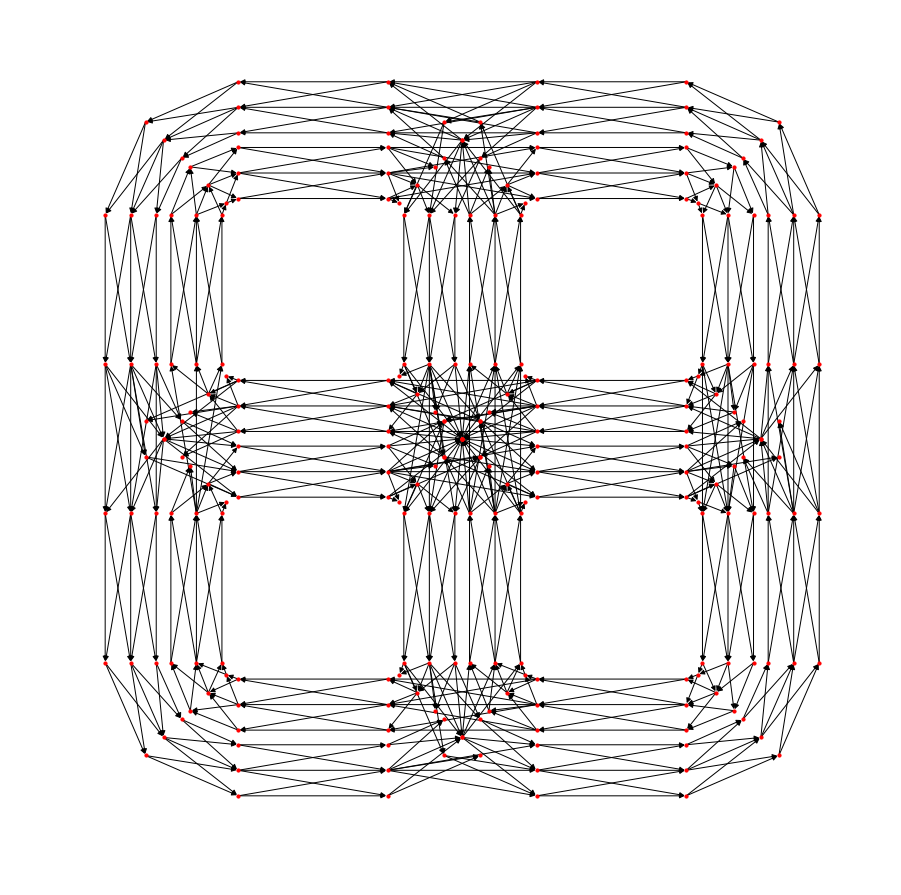

In [24]:
import geometry as geo
pos = {}
for n in sk.G:
    q = sk.G.nodes[n]['point'].as_SE2()
    t, _ = geo.translation_angle_from_SE2(q)
    pos[n] = t
draw_graph(sk.G, pos=pos)

## Planning example

Here is an example of how to do planning on the road network.

We select a start and end node:

In [ ]:
start = 'P60'
end = 'P36'

We find the shortest path:

In [ ]:
import networkx as nx
path = nx.shortest_path(sk.G, start, end)
print(path)

We retrieve the edge names:

In [ ]:
def get_lanes(path):
    edges = zip(path[:-1], path[1:]) 
    lanes  = []
    for a, b in edges:
        lane = sk.G.get_edge_data(a, b)[0]['lane']
        lanes.append(lane)
    return lanes

In [ ]:
lanes = get_lanes(path);
print(lanes)

For visualization, we create a new map containing only the lanes selected: 

In [ ]:
po = dw.PlacedObject()
for lane_name in lanes:
    lane = sk.root2.children[lane_name]
    po.set_object(lane_name, lane, ground_truth=dw.SE2Transform.identity())

In [ ]:
ipython_draw_html(po);